# Task 3: System integration and research
## Craig Atkinson a1669436

In [ ]:
class Recommendations:
    """
    Usage: Product Recommendation System with a Terminal Text Interface
    Input: Text Interface will ask for UserID and "with or without frequent patterns"
    Output: List of product recommendations the provided User
    """
    
    def __init__(self,data):
        #read the data once and assign to variable
        self.data=data
        #train the AlternatingLeastSquares model once and assign to variable
        self.trained_model=None
    
    def pattern_mining(self):
        "Version 2 of the task1 function"
        from mlxtend.preprocessing import TransactionEncoder
        from mlxtend.frequent_patterns import apriori, association_rules
        from mlxtend.frequent_patterns import fpmax, fpgrowth
        
        #group columns user and set as list
        grouped = self.data.groupby(['User_id', 'Date'])['itemDescription'].apply(list).reset_index()
        
        #only the itemDescription column as product transactions list
        transactions = grouped['itemDescription'].tolist()
        
        #encode transations list as one-Hot vector
        te = TransactionEncoder()
        te_array = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_array, columns=te.columns_)
        apriori=False
        if apriori==True:
            #use apriori algor to generation association rules
            frequent_itemsets_apriori = apriori(df_encoded, min_support=0.001, use_colnames=True)
            frequent_itemsets_apriori=frequent_itemsets_apriori.sort_values('support')
            #create association Rules
            rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1.2)
            return rules_apriori
        else:
            #use frequent Itemset Mining using FP-growth algor
            frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.001, use_colnames=True)
            rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.2)
            return rules_fp


    def collaborative_filtering(self,user_id, use_patterns):
        "Version 4 of the task2 function"
        import numpy as np
        from collections import defaultdict
        from scipy.sparse import csr_matrix
        from implicit.als import AlternatingLeastSquares
        from implicit.nearest_neighbours import bm25_weight

        def recommend_without_freqset(user_items_matrix, user_id, user_mapping, item_mapping, number_of_items=5):
        
            # user_id index
            user_index = user_mapping.index(user_id)
            recommended = model.recommend(user_index, sparse_matrix[user_index], N=number_of_items)

            recommended_items = [item_mapping[item_id] for item_id in recommended[0]]
            recommended_score = recommended[1]
        
            return recommended_items

        def recommend_with_freqset(user_items_matrix, user_id, rules, metrics, user_mapping, item_mapping, number_of_items=5):
            # Get items the user recently interacted with
            user_purchased_items = set(df[df['User_id'] == user_id]['itemDescription'].unique().tolist())
            rule_boost = defaultdict(float)
            for _, row in rules.iterrows():
                if set(row['antecedents']).issubset(set(user_purchased_items)):
                    for item in row['consequents']:
                        rule_boost[item] += row[metrics]  
                        
            user_index = user_mapping.index(user_id)
        
            # top_item can be changed
            top_item=20
            recommended = model.recommend(user_index, sparse_matrix[user_index], N=top_item)
            recommended_top_items = [(item_id, item_mapping[item_id]) for item_id in recommended[0]]
            recommended_score = recommended[1]
            
            final_scores = {}
            for index, item in enumerate(recommended_top_items):
                item_name = item[1]
                boost = rule_boost.get(item_name, 0)
                final_scores[item_name] = recommended_score[index] + boost  
        
            final_recommendations = sorted(final_scores.items(), key=lambda x: -x[1])[:5]
            final_recommendation_items = []

            for item_name, score in final_recommendations:
                final_recommendation_items.append(item_name)
        
            return final_recommendation_items

        #data preprocessing
        df=self.data
        df['days_ago'] = (df.index.max() - df.index)
        df['days_ago'] = df['days_ago'].dt.components.days
        # 120 buying patterns over 4 months
        df['recency_weight'] = np.exp(-df['days_ago'] / 120)

        
        df_user_items = df.groupby(['User_id', 'itemDescription']).agg({'Date':['count']}).reset_index()
        df_user_items.columns = ['User_id', 'itemDescription', 'frequency']
        
        # Sum weighted counts per user-item
        weighted_df = df.groupby(['User_id', 'itemDescription'])['recency_weight'].sum().reset_index()
                
        #changed to Multiply frequency × mean recency weight per user-item
        df_user_items_recency = df_user_items.merge(weighted_df, on=['User_id', 'itemDescription'])
        df_user_items_recency['final_weight'] = df_user_items_recency['frequency'] * df_user_items_recency['recency_weight']
        user_items_matrix = df_user_items_recency.pivot(index="User_id", columns="itemDescription", values="final_weight")
        user_items_matrix.fillna(0, inplace=True)
        
        #create sparse matrix from user-item matrix and apply BM25 weighing
        sparse_matrix = csr_matrix(user_items_matrix.values)
        weighted_matrix = bm25_weight(sparse_matrix.T).T

        #train the model, first use default parameters (should do parameter tuning in later versions)
        if self.trained_model==None:
            model = AlternatingLeastSquares(factors=50, regularization=0.2, iterations=20, random_state=8)
            model.fit(weighted_matrix,show_progress=0)
        else:
            model=self.trained_model

        #map the provided user id
        user_mapping = list(user_items_matrix.index)
        user_index = user_mapping.index(user_id)
        item_mapping = list(user_items_matrix.columns)
        
        #get the recommended items
        if use_patterns == 'with':
            #with pattern mining rules
            rules= self.pattern_mining()
            return recommend_with_freqset(user_items_matrix, user_id, rules=rules, metrics='lift',user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5)
        else:
            #without pattern mining rules
            return recommend_without_freqset(user_items_matrix, user_id, user_mapping=user_mapping, item_mapping=item_mapping, number_of_items=5)

    def text_program(self,user=None):
        """Runs the Text Interface, which calls the other tasks"""
        
        while True:
            if user==None:
                user_id_input = input("Enter user ID or enter 'q' to quit:\n")
                if user_id_input.lower() == 'q':
                    break
                #validate input is numerical    
                try:
                    user_id = int(user_id_input)
                except:
                    print("Please Only Enter a Numerical User ID")
                    continue

                #for a new user, recommend the 10 most popular items
                if user_id not in self.data['User_id'].unique():
                    print("New User Detected, Not in Dataset. Best Selling items:")
                    top_items = self.data['itemDescription'].value_counts().head(5).index.tolist()
                    for item in top_items:
                        print(item)
                    print("\n-------------------------------\n")
                    continue
                
                method_input = input('With or Without frequent patterns? enter "with" or "without":\n')
                use_patterns = method_input.lower()
            else:
                user_id = user
                use_patterns='without'
                
            if use_patterns in ['with', 'without']:
                recommendations = self.collaborative_filtering(user_id, use_patterns)
                print("\nProduct Recommendations for user: " + str(user_id))
                for item in recommendations:
                    print(item)
                print("\n-------------------------------\n")
            else:
                print('Please Only Enter "with" or "without" ')

if __name__ == "__main__":
    import pandas as pd
    import warnings 
    warnings.filterwarnings('ignore')

    #laod the data
    data = pd.read_csv('./data/Groceries data train.csv')
    data = data.dropna()

    #create pandas datetime index
    data['datetime'] = pd.to_datetime(data['Date'], dayfirst=True).dt.date
    data.set_index('datetime', inplace=True)
    
    print("Welcome to the Product Recommendation System")
    recommend = Recommendations(data)
    #run the program
    recommend.text_program()

Welcome to the Product Recommendation System


Enter user ID or enter 'q' to quit:
 1004
With or Without frequent patterns? enter "with" or "without":
 with



Product Recommendations for user: 1004
detergent
hamburger meat
processed cheese
photo/film
waffles

-------------------------------



In [ ]:
data_testing = pd.read_csv('Groceries data test.csv')
data = pd.read_csv('Groceries data train.csv')
data = data.dropna()

#create pandas datetime index
data['datetime'] = pd.to_datetime(data['Date'], dayfirst=True).dt.date
data.set_index('datetime', inplace=True)

recommend = Recommendations(data)

for user in data['User_id']:
    recommendations = recommend.text_program(user)
    history = data_testing[data_testing['user_id']==user]
    for item in recommendations:
        if item in list(history['itemDescription']):
            print(user,' yes!!')
    
    

processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise
processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise
processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise
processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise
processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise
processed cheese
sparkling wine
misc. beverages
frozen fish
mayonnaise


## Exploratory Data Analysis 
Plots and statsistics of training dataset, for the group report

User Average Number of Purchases:
 count    3493.000000
mean        5.548812
std         3.238378
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        24.000000
Name: count, dtype: float64


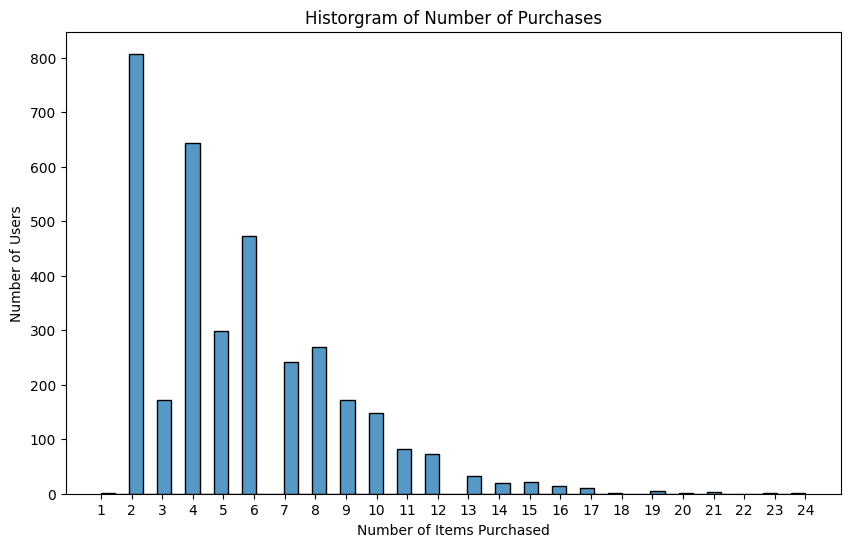

In [2]:
#EDA
import matplotlib.pyplot as plt
import seaborn as sns

#average user statisics
user_counts = data['User_id'].value_counts()
print("User Average Number of Purchases:\n", user_counts.describe())

#historgram of Number of Purchases
plt.figure(figsize=(10, 6))
sns.histplot(user_counts, bins=50)
plt.title('Historgram of Number of Purchases')
plt.xlabel('Number of Items Purchased')
plt.ylabel('Number of Users')
plt.xticks(range(1,25))
plt.show()

Top 20 most popular items:
 itemDescription
whole milk               1135
other vegetables          916
rolls/buns                878
soda                      816
yogurt                    678
bottled water             525
root vegetables           512
shopping bags             455
pastry                    421
tropical fruit            410
whipped/sour cream        376
newspapers                353
bottled beer              344
brown bread               341
domestic eggs             336
pip fruit                 315
fruit/vegetable juice     313
margarine                 302
canned beer               291
citrus fruit              291
Name: count, dtype: int64
Bottom 20 least popular items:
 itemDescription
cooking chocolate         9
flower soil/fertilizer    8
frozen fruits             7
fish                      7
cookware                  7
cream                     7
decalcifier               5
liqueur                   5
organic products          5
toilet cleaner            5
ha

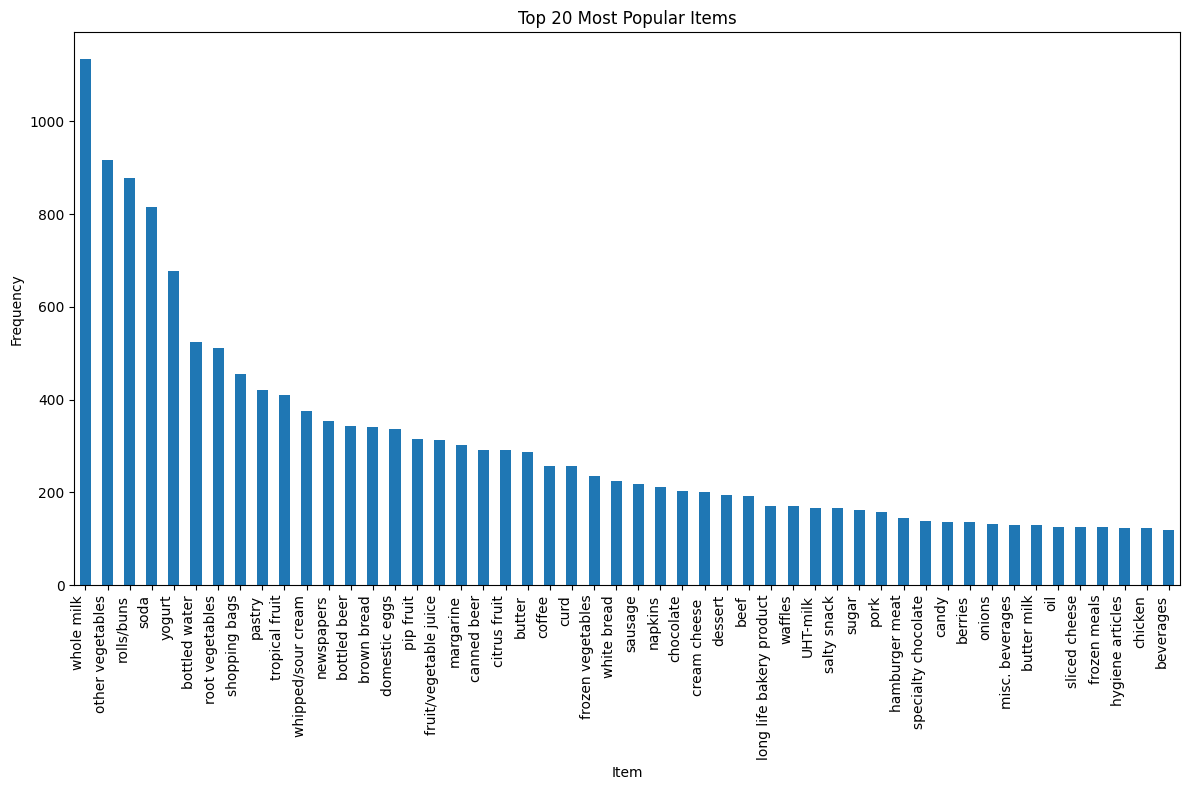

In [3]:
item_counts = data['itemDescription'].value_counts()

print("Top 20 most popular items:\n", item_counts.head(20))
print("Bottom 20 least popular items:\n", item_counts.tail(20))

plt.figure(figsize=(12, 8))
item_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Popular Items')
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

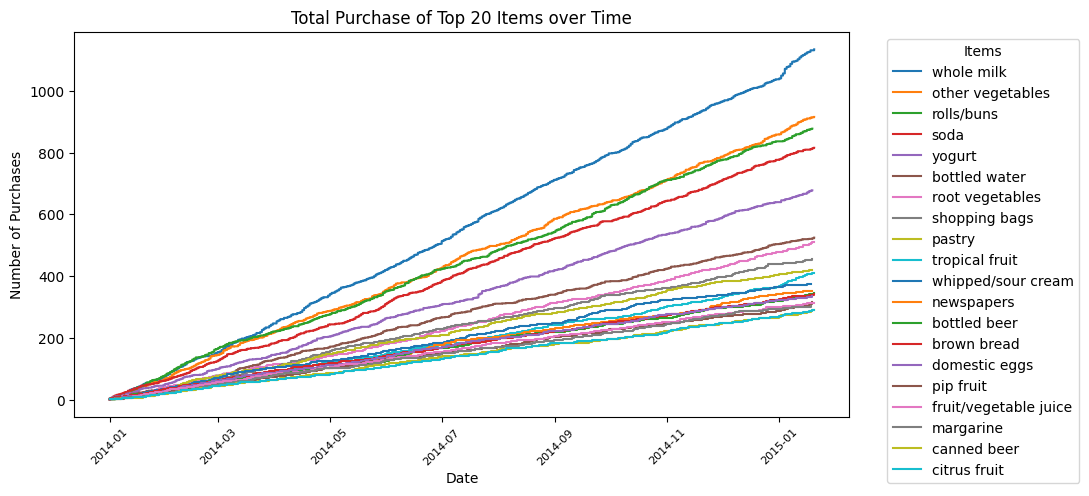

In [37]:
#convert creation time column to pandas datetime type
data=data.dropna()
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data= data.sort_values('Date')
plt.figure(figsize=(10, 5))

#for each cluster, create a time series line
for item in item_counts.head(20).keys():
    item_data = data[data['itemDescription'] == item]
    
    dates = item_data['Date']
    counts = range(1, len(item_data) + 1)
    #plot each post in the cluster as a timestep
    plt.step(dates, counts, where='post', label=f'{item}')

plt.title('Total Purchase of Top 20 Items over Time')
plt.xlabel('Date')
plt.xticks(rotation=45, fontsize=8)
plt.ylabel('Number of Purchases')
plt.legend(title='Items', loc='upper left', bbox_to_anchor=(1.04, 1))

plt.show()



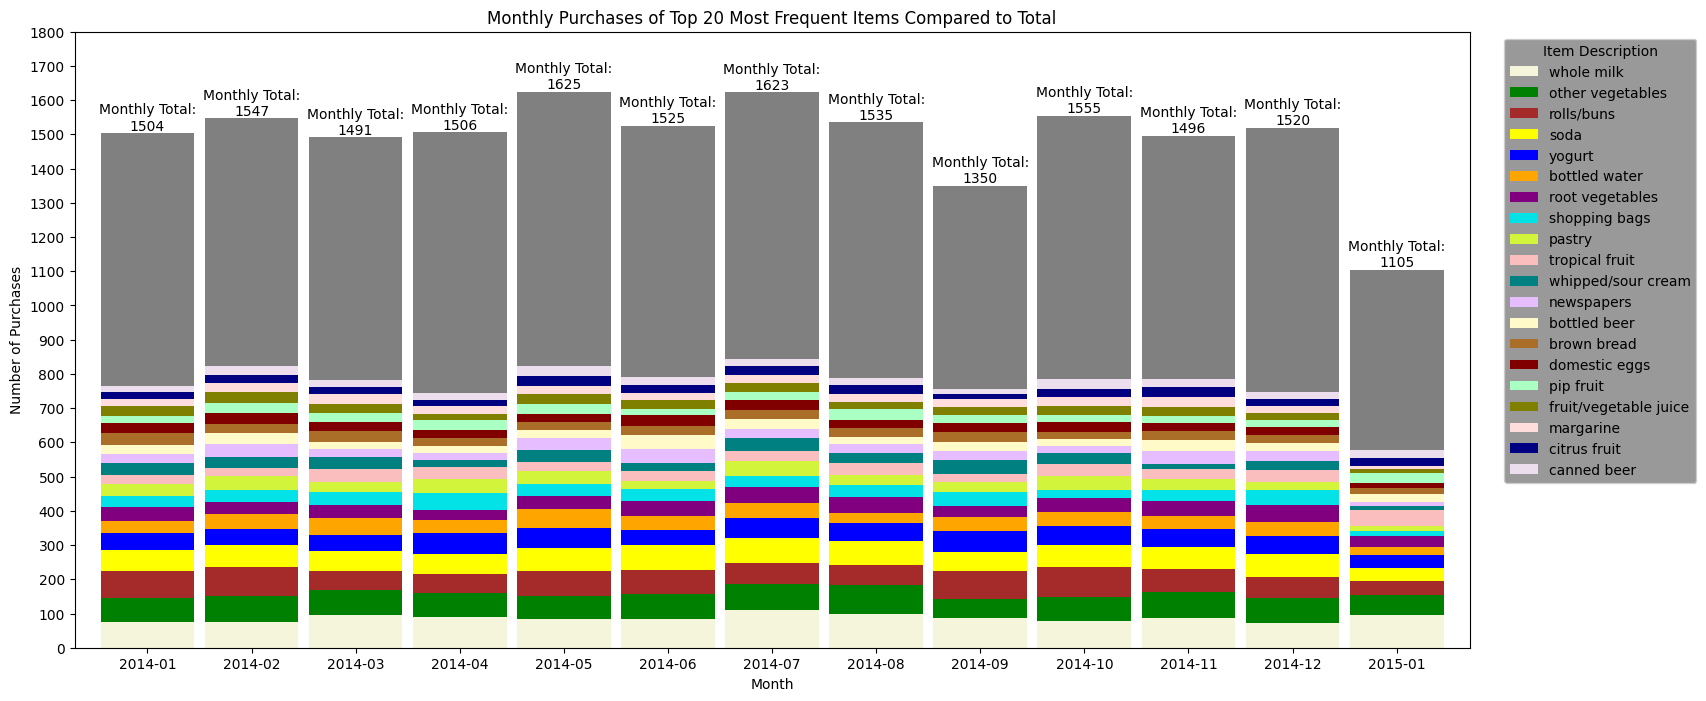

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#year-month for monthly calculation '2014-01'
data['YearMonth'] = data['Date'].dt.to_period('M')

#total counts per month
monthly_counts = data.groupby(['YearMonth']).size()

#group by year-month and item name
monthly_counts_item = data.groupby(['YearMonth', 'itemDescription']).size()
pivot_data_item = monthly_counts_item.unstack(fill_value=0)

item_totals = data['itemDescription'].value_counts()
top_n_items = item_totals.head(20).index.tolist()
pivot_data_to_plot = pivot_data_item[top_n_items]

fig, ax = plt.subplots(figsize=(18, 8))
monthly_counts.plot(kind='bar', ax=ax, width=0.9, color='grey')

# Add labels to the grey bars
for p in ax.patches[:len(monthly_counts)]:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2., height,'Monthly Total:\n%d' % int(height), ha='center', va='bottom')


colors = ['beige', 'green', 'brown', 'yellow', 'blue', 'orange', 'purple', '#03e2e6', '#d2f53c', '#fabebe', 
          '#008080', '#e6beff', '#fffac8', '#aa6e28', '#800000', '#aaffc3', '#808000', '#ffdddd', '#000080', '#eddeee']

pivot_data_to_plot.plot(kind='bar', stacked=True, ax=ax, width=0.9, color=colors)
ax.set_title('Monthly Purchases of Top 20 Most Frequent Items Compared to Total')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases')
ax.tick_params(axis='x', rotation=0)
legend = plt.legend(title='Item Description', bbox_to_anchor=(1.02, 1), loc='upper left', facecolor='grey')
plt.yticks(range(0,1850,100))
plt.show()

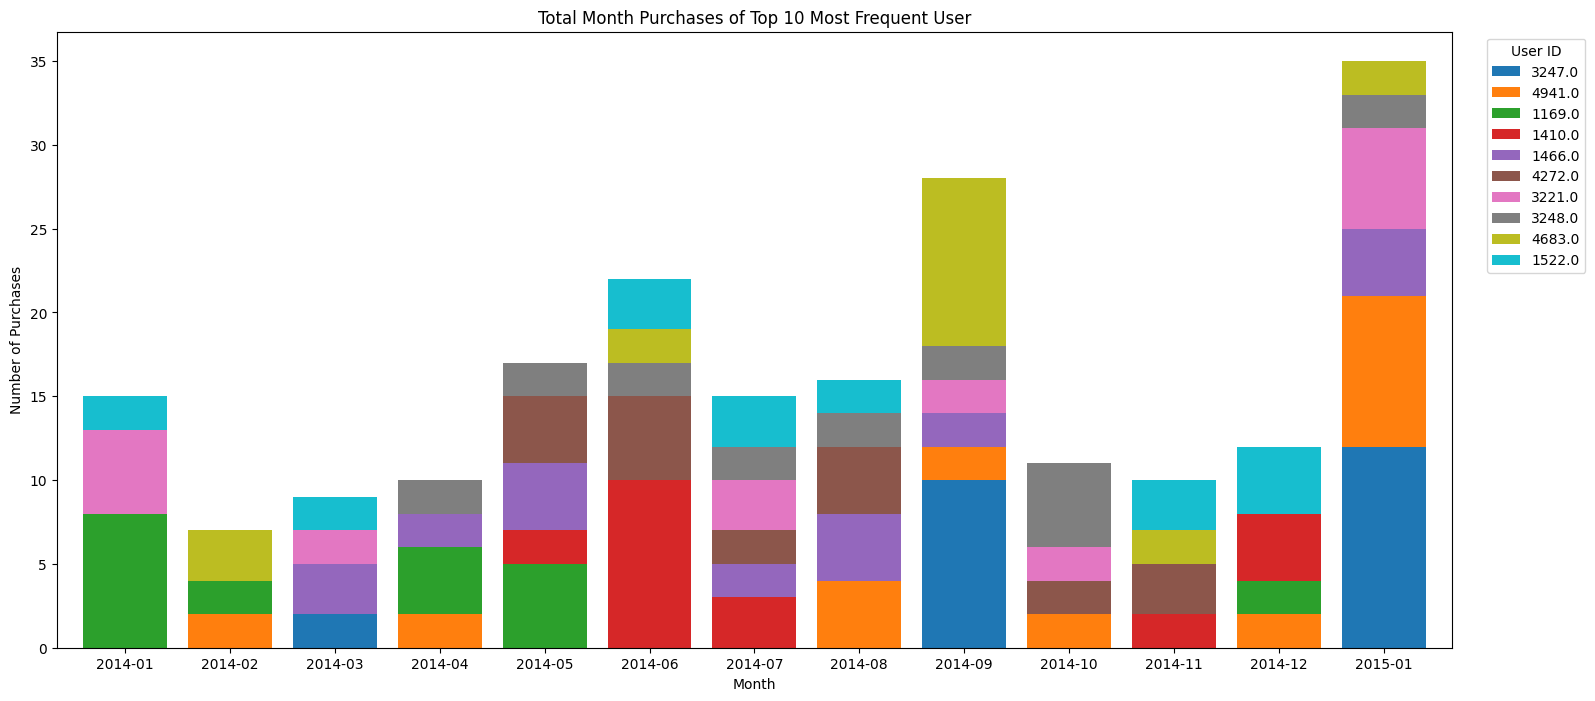

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

#year-month for monthly calculation '2014-01'
data['Date']
data['YearMonth'] = data['Date'].dt.to_period('M')

#total counts per month
monthly_counts = data.groupby(['YearMonth']).size()

#group by year-month and item name
monthly_counts_item = data.groupby(['YearMonth', 'User_id']).size()
pivot_data_item = monthly_counts_item.unstack(fill_value=0)

item_totals = data['User_id'].value_counts()
top_n_items = item_totals.head(10).index.tolist()
pivot_data_to_plot = pivot_data_item[top_n_items]

fig, ax = plt.subplots(figsize=(18, 8))
pivot_data_to_plot.plot(kind='bar', stacked=True, ax=ax, width=0.8)
ax.set_title('Total Month Purchases of Top 10 Most Frequent User')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Purchases')
ax.tick_params(axis='x', rotation=0)
legend = plt.legend(title='User ID', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()


## Reflection

In version 1 of the program, the Recommendation System was created as a python program. The program is made up of a main routine and a object class called "Recommendations". The object "Recommendations" has three main functions, "pattern_mining", "collaborative_filtering", and "text_program". In this version of the program, "pattern_mining", "colabrative_filtering" are placeholder functions for the work of the other group members (group task 1 and 2). The function "text_program" is what the program user will interactive to get the results. It first prompts the user for to input a userID number and ask for the "with or without" input. The function will then called the "pattern_mining", "colabrative_filtering functions and then return the product recommendations. The program will then continue to loop until the user inputs the 'q' command to quit.

In version 2 of the program, an error was found if the user inputs a non-numerical input string when asked for userID, this was fixed by validating the input and outputing a try again message to the user, which avoids the program crashing with an error message. Additionally, some EDA statsistics and graphs were generated in the jupyter notebook, which will help the group better understand the dataset and be used in the group report.

In version 3 of the program, the first versions of task 1 and task 2 were added to the Reccommendations functions "pattern_mining" and "collaborative_filtering". The "collaborative_filtering" method is working using the "implicit" python module, I added the ignore warnings and show_progress=false so that the user does not see unessessary warnings while using the program. The output of the "collaborative_filtering" function is providing recommended items based on similar users as expected. However, the 'with frequent patterns' option has not yet been implimented due to issues with the "pattern_mining" function. The current implimentation of the "pattern_mining" function is not providing the patterns and is returning an empty DataFrame.

In version 4 of the program, the second versions of task 1 and task 2 were added to the Reccommendations functions "pattern_mining" and "collaborative_filtering". The "with or without" frequent items option correctly implemented, where the "with" option reccommends items using the accosiation rules from the "pattern_mining" function and the results of the "collaborative_filtering" model. I also noticed that if the userID input is not in the training data it will crash the program with an error. 
